<!-- # The three acts of building a ultimate ML model

## Start with a baseline model, understand the dataset, evaluation function
## Build a robust model with RandomForest/XGB/LGBM/CatBoost etc., 
        a. hyperparameter tuning
        b. feature engineering
        c. feature selection
## Apply step 2 & 2.a for multiple models. Stack them -->

In [1]:
%%html
<h1 style="text-align: center; font-size: 8rem">Act-I</h1>
<h2>Steps:</h2>
<ol>
    <li>read data</li>
    <li>variable study</li>
    <li>prepare training dataset (fill nulls, transform numerical, categorical & ordinal columns)</li>
    <li>train a base model</li>
    <li>submit & check the score</li>
</ol>

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
# imports
from utils import *


In [15]:
# config

dataset_path, result_path = get_paths()
config_output()

print([_.name for _ in dataset_path.iterdir()])

setting no. of rows displayed: 1000
setting no. of columns displayed: 1000
setting warnings to be ignored.


['data_description.txt', 'train.csv', '.ipynb_checkpoints', 'train_with_folds.csv', 'test.csv', 'sample_submission.csv', 'test_with_folds.csv']


### read data

In [4]:
train_df = pd.read_csv(dataset_path/"train.csv")
test_df = pd.read_csv(dataset_path/"test.csv")
sample_subm_df = pd.read_csv(dataset_path/"sample_submission.csv")

print(train_df.shape, test_df.shape)

(1460, 81) (1459, 80)


### variable study

In [5]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### Identify numerical and categorical columns

In [6]:
ordinal_cols = [
    "MSSubClass",
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "HeatingQC",
    "KitchenQual",
    "Functional",
    "FireplaceQu",
    "GarageQual",
    "GarageFinish",
    "GarageCond",
    "PoolQC",
    "Fence",
]

num_cols = [
    "LotFrontage",
    "LotArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    # can they be ordinal columns
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    #
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MasVnrArea",
]

cat_cols = [
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",  # can it be an ordinal variable
    "Utilities",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "Heating",
    "CentralAir",
    "Electrical",
    "GarageType",
    "PavedDrive",
    "MiscFeature",
    "MoSold",
    "SaleType",
    "SaleCondition",
]

year_cols = [
    "GarageYrBlt",
    "YearBuilt",
    "YrSold",
    "YearRemodAdd",
]

#### target variable study
1. Continuous variable
2. As we can see below, target variable is heavily skewed to the right. 
3. One thing we can do to make it normal is to apply log transform, as we can see in the right plot below

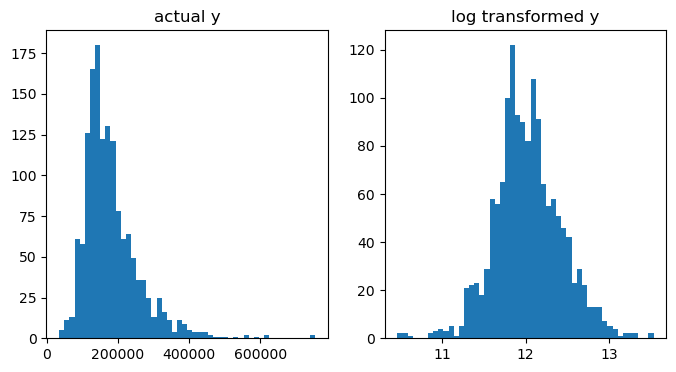

In [7]:
target = train_df.SalePrice
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].hist(target, bins=50)
ax[1].hist(np.log1p(target), bins=50)
ax[0].set_title("actual y")
ax[1].set_title("log transformed y")
plt.show()

### prepare training dataset
1. creating pipeline
    1. imputing nulls
        1. most_frequent for ordinal & categorical
        2. mean for numerical columns
    2. transform
        1. categorical to one-hot-encoding
        2. apply nomalization on numerical columns

In [8]:
def get_null_pct_df(df, threshold=None):
    null_cols = df.columns[df.isnull().sum() != 0]
    null_val_pct = df[null_cols].isnull().sum() * 100 / len(df)
    null_val_pct = null_val_pct.sort_values(ascending=False)
    null_val_pct = null_val_pct.to_frame().reset_index()
    null_val_pct.columns = ["feature_name", "null_pct"]
    null_val_pct["_type"] = None
    for idx, row in null_val_pct.iterrows():
        feature_name =  row["feature_name"]
        if feature_name in ordinal_cols:
            null_val_pct.loc[idx, "_type"] = "ordinal"
        elif feature_name in num_cols:
            null_val_pct.loc[idx, "_type"] = "numeric"
        elif feature_name in cat_cols:
            null_val_pct.loc[idx, "_type"] = "categorical"
        elif feature_name in year_cols:
            null_val_pct.loc[idx, "_type"] = "year"
            
    if threshold:
        null_val_pct = null_val_pct[null_val_pct.null_pct < threshold]
    return null_val_pct

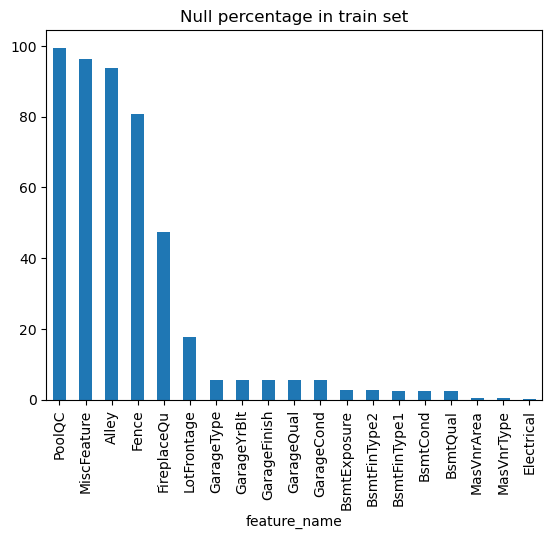

In [9]:
train_null_pct_df = get_null_pct_df(train_df)
test_null_pct_df = get_null_pct_df(test_df, threshold=80)
train_null_pct_df.plot(kind="bar", x="feature_name", y="null_pct", title="Null percentage in train set", legend=False)
plt.show()

In [10]:
not_useful_cols = ["Id", "SalePrice"]

ordinal_cols = [col for col in ordinal_cols if col not in not_useful_cols]
num_cols = [col for col in num_cols if col not in not_useful_cols]
cat_cols = [col for col in cat_cols if col not in not_useful_cols]
year_cols = [col for col in year_cols if col not in not_useful_cols]

useful_cols = ordinal_cols + num_cols + cat_cols + year_cols

In [11]:
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [12]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.cols]

In [13]:
cat_pipe_cols = cat_cols
cat_pipe = Pipeline([
    ("select_cols", ColumnSelector(cat_pipe_cols)),
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("dummies", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe_cols = num_cols + year_cols  # we will apply same transformations to num & year columns
num_pipe = Pipeline([
    ("select_cols", ColumnSelector(num_pipe_cols)),
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", RobustScaler()),
])

ord_pipe_cols = ordinal_cols
ord_pipe = Pipeline([
    ("select_cols", ColumnSelector(ord_pipe_cols)),
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("inorder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

### Model building

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [15]:
n_splits = 7
train_df["fold"] = None
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=13)
for fold_no, (train_ix, test_ix) in enumerate(kfold.split(train_df)):
    train_df.loc[test_ix, "fold"] = fold_no

# save dataframes with folds for later use
train_df.to_csv(dataset_path/"train_with_folds.csv", index=False)
test_df.to_csv(dataset_path/"test_with_folds.csv", index=False)

train_df.fold.value_counts()

1    209
0    209
3    209
2    209
6    208
4    208
5    208
Name: fold, dtype: int64

In [16]:
fold_scores = []
for fold in range(n_splits):
    xtrain = train_df.loc[train_df.fold != fold, useful_cols]
    xtest = train_df.loc[train_df.fold == fold, useful_cols]
    ytrain = train_df.loc[train_df.fold != fold, "SalePrice"]
    ytest = train_df.loc[train_df.fold == fold, "SalePrice"]
    
    feature_transformer = ColumnTransformer([
                                    ("cat", cat_pipe, cat_cols),
                                    ("num", num_pipe, num_cols + year_cols),
                                    ("ord", ord_pipe, ordinal_cols),
                                ])
    
    xtrain = feature_transformer.fit_transform(xtrain)
    xtest = feature_transformer.transform(xtest)
    
    model = RandomForestRegressor(n_estimators=500, random_state=13)
    model.fit(xtrain, ytrain)
    ypreds = model.predict(xtest)
    fold_rmse = mean_squared_log_error(ytest, ypreds, squared=False)
    fold_scores.append(fold_rmse)
    print(f"fold: {fold+1}; rmse: {fold_rmse:.4f}")

print(f"\nAverage fold score: {np.mean(fold_scores):.4f}")

fold: 1; rmse: 0.1667
fold: 2; rmse: 0.1636
fold: 3; rmse: 0.1223
fold: 4; rmse: 0.1359
fold: 5; rmse: 0.1460
fold: 6; rmse: 0.1296
fold: 7; rmse: 0.1456

Average fold score: 0.1442


> Pretty good average score for a cross-validation. Lets go ahead and build model on the full dataset and submit

In [17]:
xtrain = feature_transformer.fit_transform(train_df[useful_cols])
xtest = feature_transformer.transform(test_df[useful_cols])
model = RandomForestRegressor(n_estimators=500, random_state=13)

model.fit(xtrain, train_df.SalePrice)
preds = model.predict(xtest)

sample_subm_df["SalePrice"] = preds

sample_subm_df.to_csv(result_path/"submission.csv", index=False)

> I got a score of "0.14614" on kaggle submission, which is okayish for a simple model without any feature engineering and model tuning. Lets dive into Act-II to perform these steps